[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373966  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687307  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689529  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021717  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944683  237458000
Epoch 1/20
30/30 [==============================] - 5s 37ms/step - loss: 0.0096
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 9.4927e-04
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 7.5893e-04
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 7.2048e-04
Epoch 5/20
30/30 [==============================] - 1s 30ms/step - loss: 6.8894e-04
Epoch 6/20
30/30 [===========================

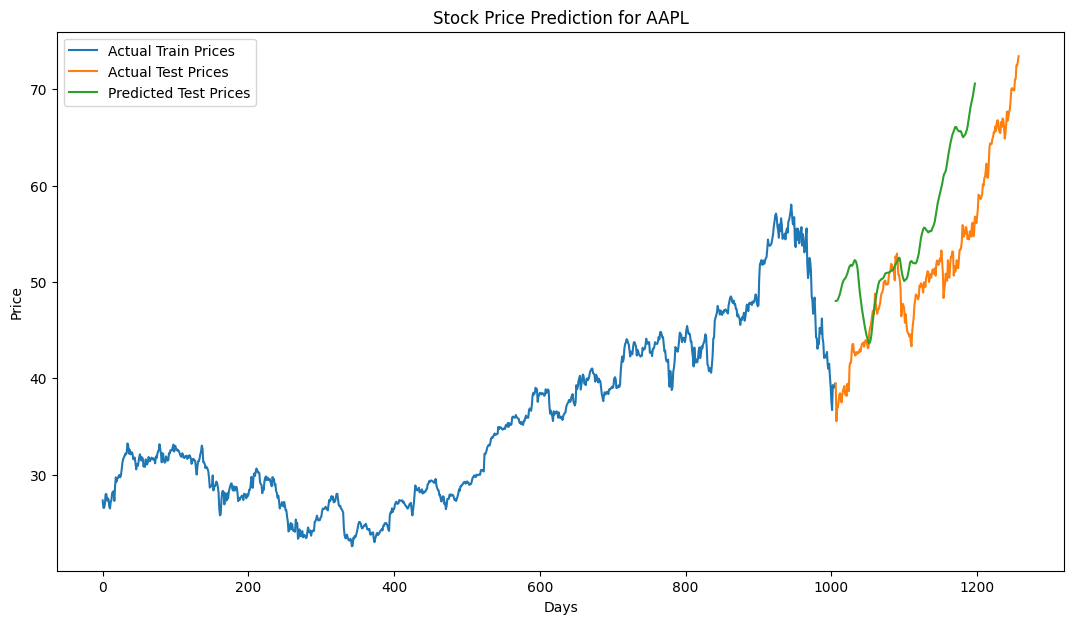

RMSE: 1.4883637877224214


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

stock_symbol = 'AAPL'  
data = yf.download(stock_symbol, start='2015-01-01', end='2020-01-01')
print(data.head())

data = data[['Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=60):
    X, y = [], [] 
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)

X_test, y_test = create_dataset(test_data)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

train_actual = scaler.inverse_transform(train_data)
test_actual = scaler.inverse_transform(test_data)

plt.figure(figsize=(13, 7))
plt.plot(train_actual, label='Actual Train Prices')
plt.plot(np.arange(len(train_actual), len(train_actual) + len(test_actual)), test_actual, label='Actual Test Prices')
plt.plot(np.arange(len(train_actual), len(train_actual) + len(test_predictions)), test_predictions, label='Predicted Test Prices')
plt.title(f'Stock Price Prediction for {stock_symbol}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_actual[60:], test_predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

model.save('Stock Price Prediction Model.keras')

In [2]:

predicted_stock_prices = pd.DataFrame({
    'Date': data.index[train_size + 60:],
    'Actual': test_actual[60:].flatten(),
    'Predicted': test_predictions.flatten()
})

predicted_stock_prices.to_csv('predicted_stock_prices_2020.csv', index=False)
print("Predictions saved to predicted_stock_prices.csv")

Predictions saved to predicted_stock_prices.csv
